# stackoverflow developer survey
> EDA and salary modelling

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [machine-learning, regression]

The aim of this post is to do some exploration of the [stack overflow developer survey 2018 dataset](https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey) and some modelling regarding salary. As a bonus point, we'll discuss some properties of the mean absolute error.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None) 


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklego.preprocessing import PandasTypeSelector
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error

from lightgbm import LGBMRegressor

from category_encoders import TargetEncoder

In [2]:
so_df = pd.read_csv('stackoverflow.csv', low_memory=False)

### Exploratory data analysis

Let's have a quick look at the data that we have available

In [3]:
so_df.head()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,JobContactPriorities3,JobContactPriorities4,JobContactPriorities5,JobEmailPriorities1,JobEmailPriorities2,JobEmailPriorities3,JobEmailPriorities4,JobEmailPriorities5,JobEmailPriorities6,JobEmailPriorities7,UpdateCV,Currency,Salary,SalaryType,ConvertedSalary,CurrencySymbol,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,NumberMonitors,Methodology,VersionControl,CheckInCode,AdBlocker,AdBlockerDisable,AdBlockerReasons,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,AdsActions,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,30 or more years,18-20 years,Moderately dissatisfied,Neither satisfied nor dissatisfied,Working in a different or more specialized tec...,I am actively looking for a job,More than 4 years ago,1.0,7.0,10.0,8.0,2.0,5.0,4.0,3.0,6.0,9.0,1.0,5.0,3.0,7.0,10.0,4.0,11.0,9.0,6.0,2.0,8.0,3.0,1.0,5.0,2.0,4.0,1.0,3.0,4.0,5.0,2.0,6.0,7.0,I saw an employer’s advertisement,British pounds sterling (£),51000,Yearly,70841.0,GBP,Confluence;Office / productivity suite (Micros...,One to three months,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,NaN,NaN,Agree,Agree,Neither Agree nor Disagree,JavaScript;Python;Bash/Shell,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React,IPython / Jupyter;Sublime Text;Vim,Linux-based,2,NaN,Git;Subversion,A few times per week,Yes,Yes,The website I was visiting asked me to disable it,Somewhat agree,Neither agree nor disagree,Neither agree nor disagree,NaN,3.0,5.0,1.0,4.0,6.0,7.0,2.0,Increasing automation of jobs,Increasing automation of jobs,The developers or the people creating the AI,I'm excited about the possibilities more than ...,Depends on what it is,Depends on what it is,Upper management at the company/organization,Yes,10 (Very Likely),A few times per month or weekly,Yes,A few times per month or weekly,Yes,"No, I have one but it's out of date",7,Yes,A little bit interested,A little bit interested,A little bit interested,A little bit interested,A little bit interested,Between 6:01 - 7:00 AM,5 - 8 hours,30 - 59 minutes,Never,Ergonomic keyboard or mouse,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
1,7,Yes

We can see that most columns are non-numeric. Some of the few columns that are numeric are `AssessJob*`. Having a look at the [data schema](https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey?select=survey_results_schema.csv), we can see that users have to rank several features of the job that they're choosing from 1 to 10, where 1 is the most important and 10 is the least important.  In the case of `AssessJob5`, the thing that is being rated is *The compensation and benefits offered*. A natural question to ask is that if people who value compensation more actually make more. The answer is in the following query:

In [4]:
(so_df
 .groupby('AssessJob5')
 .agg({'ConvertedSalary': ['mean', 'median', len]})
)

ConvertedSalary                 
                      mean   median     len
AssessJob5                                 
1.0          114636.509475  67512.0  9235.0
2.0          104268.116033  63257.0  8782.0
3.0           94250.374226  58340.0  7263.0
4.0           89597.748557  52872.0  5719.0
5.0           89341.969460  51408.0  4355.0
6.0           81042.514268  45420.0  3259.0
7.0           88240.893902  41124.0  2460.0
8.0           74418.464066  37572.0  1948.0
9.0           80024.848718  35178.0  1560.0
10.0          66614.714586  28800.0   953.0

Indeed, people who rate the compensation as more important make on average more, both in terms of mean and median.

Before asking and attempting to answer more questions regarding the salary, let's make some utility functions that will be useful.

In [5]:
def p10(x: pd.Series) -> float:
    """Function that returns the 10th percentile of a pandas Series"""
    return x.quantile(.10)

def p90(x: pd.Series) -> float:
    """Function that returns the 90th percentile of a pandas Series"""
    return x.quantile(.90)

def salary_summary(so_df: pd.DataFrame, var: str) -> pd.DataFrame:
    """Summaries several statistics of the salary grouping by a variable"""
    return (so_df
            .groupby(var)
            .agg({'ConvertedSalary': ['min', p10, 'median', p90, 'mean', 'max', len]})
           )

`salary_summary` describes some statistics with respect to some grouping variable. Let's use `YearsCoding` as that variable. We can see that more years coding generally imply higher salaries. 

In [6]:
salary_summary(so_df, 'YearsCoding')

ConvertedSalary                                              \
                             min      p10    median       p90           mean   
YearsCoding                                                                    
0-2 years                    0.0   1200.0   13212.0   76119.1   51609.611982   
12-14 years                  0.0  23094.3   67313.5  148801.9  109875.912365   
15-17 years                  0.0  31300.6   76626.5  165000.0  124343.801985   
18-20 years                  0.0  35244.0   85000.0  175000.0  128760.426768   
21-23 years                  0.0  41229.0   95552.0  175000.0  133128.075183   
24-26 years                  0.0  38798.4   96000.0  200000.0  145374.963762   
27-29 years                  0.0  41671.0   96000.0  200000.0  153732.023772   
3-5 years                    0.0   4128.0   29376.0   96000.0   66707.942685   
30 or more years             0.0  48616.0  105000.0  205586.2  155413.456875   
6-8 years                    0.0   7725.9   44287.0  115500.0   83373.084229   
9-11 years                   0.0  14662.5   55392.0  130000.0   94310.455866   

                                      
                        max      len  
YearsCoding                           
0-2 years         2000000.0   3188.0  
12-14 years       2000000.0   4998.0  
15-17 years       2000000.0   3828.0  
18-20 years       2000000.0   3168.0  
21-23 years       2000000.0   1636.0  
24-26 years       2000000.0   1159.0  
27-29 years       2000000.0    631.0  
3-5 years         2000000.0   9788.0  
30 or more years  2000000.0   2029.0  
6-8 years         2000000.0  10234.0  
9-11 years        2000000.0   7024.0

We can actually attempt to plot the evolution of the median salary in terms of years spent programming:

In [7]:
so_df['years_coding_int'] = so_df.YearsCoding.map({
    '30 or more years': 35, 
    '6-8 years': 7, 
    '9-11 years': 10, 
    '0-2 years': 1,
    '15-17 years': 16,
    '18-20 years': 19,
    '3-5 years': 4,
    '12-14 years': 13,
    '24-26 years': 25, 
    '21-23 years': 22, 
    '27-29 years:': 28
})

In [8]:
year_summary = salary_summary(so_df, 'years_coding_int')

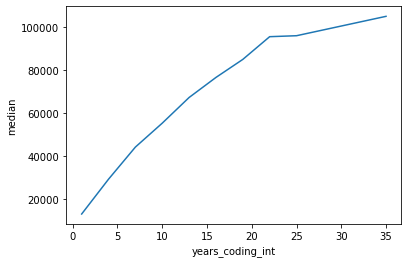

In [9]:
sns.lineplot(year_summary.index, year_summary.ConvertedSalary['median'])

A somehow expected results, the median salary increases fast at first and it slows down after some years. I did expect the saturation to happen earlier, but I was wrong apparently. 

We also had a bit of a mess to get the median salary, so we'll create a helper function to create a tidier structure.

In [10]:
def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Tidy the structure of the output of salary_summary"""
    df.columns = ["_".join(df) for df in df.columns.ravel()]
    return df

#### Country evaluation

Let's see in which countries you can make more money in terms of the median. We'll use the `flatten_columns` function to be able to sort in an easier way:

In [11]:
flatten_columns(salary_summary(so_df, 'Country')).\
sort_values('ConvertedSalary_median', ascending=False)

,ConvertedSalary_min,ConvertedSalary_p10,ConvertedSalary_median,ConvertedSalary_p90,ConvertedSalary_mean,ConvertedSalary_max,ConvertedSalary_len
Country,,,,,,,
Andorra,48955.0,49689.4,525701.5,1000000.0,525089.500000,1000000.0,4.0
Botswana,140000.0,146000.0,170000.0,194000.0,170000.000000,200000.0,2.0
Saint Lucia,159852.0,159852.0,159852.0,159852.0,159852.000000,159852.0,1.0
Togo,24000.0,51095.5,159477.5,267859.5,159477.500000,294955.0,2.0
Sierra Leone,120000.0,120000.0,120000.0,120000.0,120000.000000,120000.0,1.0
...,...,...,...,...,...,...,...
Swaziland,1488.0,1586.4,1980.0,3564.0,2476.000000,3960.0,3.0
Cuba,156.0,794.4,1944.0,58800.0,62919.368421,1000000.0,19.0
Zambia,1824.0,1824.0,1824.0,1824.0,1824.000000,1824.0,1.0


Let's stop for a moment and analyse the issues of what we are doing:
* The code starts to look messy, it's hard to read and reason about: We'll use cleaner code from now on.
* I'd never say that Togo is a top-earning country. An issue that we have is that top countries are the ones that have low statistical mass (the last column is the number of surveys answered in that country): We'll filter the countries that have more than `x` surveys to answer this question propperly.

To write cleaner code, we can use pandas pipes. This was a big lesson to me, now I'm able to write dplyr-like code in pandas. 

To solve the issue of low statistical mass, we only consider countries that have more than 40 surveys finished. The results make more sense from a macroeconomic perspective, being the US and Switzerland the top earning countries:

In [12]:
(so_df
 .pipe(salary_summary, 'Country')
 .pipe(flatten_columns)
 .query('ConvertedSalary_len > 40')
 .sort_values('ConvertedSalary_median', ascending=False)
 .head(10)
)

,ConvertedSalary_min,ConvertedSalary_p10,ConvertedSalary_median,ConvertedSalary_p90,ConvertedSalary_mean,ConvertedSalary_max,ConvertedSalary_len
Country,,,,,,,
United States,0.0,50000.0,100000.0,175000.0,154413.128506,2000000.0,12941.0
Switzerland,0.0,20938.4,93842.0,162451.6,138111.567812,1000000.0,553.0
Israel,0.0,35112.0,90642.0,140392.4,99560.527149,1248000.0,442.0
Norway,0.0,53152.0,82890.0,183633.2,150544.824926,1000000.0,337.0
Denmark,0.0,37640.0,82836.0,139878.0,100477.157303,1000000.0,356.0
Australia,0.0,41506.0,79973.0,149950.0,126623.720339,1000000.0,1180.0
Ireland,0.0,35492.0,74657.0,734328.0,186313.216718,1000000.0,323.0
New Zealand,0.0,33619.0,65776.0,166632.0,133835.951768,1000000.0,311.0
Canada,0.0,32209.0,64417.0,112730.0,100894.343419,2000000.0,1983.0


We can also measure salary inequality in a given country. A common approach is to divide the 90th quantile by the 10th quantile. The bigger this ratio, the higher the inequality. Venezuela, Viet Nam and Nigeria seem to be the most unequal countries:

In [13]:
(so_df
 .pipe(salary_summary, 'Country')
 .pipe(flatten_columns)
 .assign(inequality=lambda x: x['ConvertedSalary_p90'] / x['ConvertedSalary_p10'])
 .query('ConvertedSalary_len > 40')
 .sort_values('inequality', ascending=False)
 .head(10)
)

,ConvertedSalary_min,ConvertedSalary_p10,ConvertedSalary_median,ConvertedSalary_p90,ConvertedSalary_mean,ConvertedSalary_max,ConvertedSalary_len,inequality
Country,,,,,,,,
"Venezuela, Bolivarian Republic of...",24.0,444.0,8100.0,1000000.0,241823.625000,1000000.0,48.0,2252.252252
Viet Nam,0.0,792.0,9516.0,38400.0,19001.617284,285744.0,81.0,48.484848
Nigeria,0.0,829.0,6000.0,39196.8,23543.699248,1000000.0,133.0,47.282027
"Iran, Islamic Republic of...",0.0,660.0,10000.0,25509.6,15644.191419,1000000.0,303.0,38.650909
Other Country (Not Listed Above),0.0,6273.6,35274.5,162512.0,94657.119048,1056000.0,42.0,25.904106
Kenya,0.0,1922.4,12000.0,44400.0,30356.666667,360000.0,57.0,23.096130
Morocco,0.0,2592.0,12000.0,54046.4,20565.981132,100000.0,53.0,20.851235
India,0.0,2256.0,9396.0,46963.0,27694.121486,2000000.0,4091.0,20.816933
Ireland,0.0,35492.0,74657.0,734328.0,186313.216718,1000000.0,323.0,20.689958


#### Skills evaluation

Some columns have information regarding past experience. For instance, we have `DatabaseWorkedWith`. Wether this is null or not indicates if the user has experience working with databases. We're going to have a look at several experience questions to create features regarding no experience.

In [14]:
def na_performance(so_df: pd.DataFrame, var: str) -> pd.DataFrame:
    """Summarizes the salary statistics grouping by a variable being empty"""
    
    return (so_df
            .assign(some_experience = lambda x: ~x[var].isnull())
            .pipe(salary_summary, 'some_experience')
    )

Having db experience increases the salary in mean and median.

In [15]:
(so_df
 .pipe(na_performance, 'DatabaseWorkedWith')
)

ConvertedSalary                                           \
                            min     p10   median       p90          mean   
some_experience                                                            
False                       0.0  5640.0  53851.0  146198.8  93548.955018   
True                        0.0  7884.0  55447.5  140764.0  96172.055854   

                                     
                       max      len  
some_experience                      
False            2000000.0   7114.0  
True             2000000.0  40588.0

Having framework experience increases the salary in all statistics.

In [16]:
(so_df
 .pipe(na_performance, 'FrameworkWorkedWith')
)

ConvertedSalary                                           \
                            min     p10   median       p90          mean   
some_experience                                                            
False                       0.0  5640.0  50000.0  138660.0  88335.792343   
True                        0.0  9012.0  57912.0  145000.0  99228.131023   

                                     
                       max      len  
some_experience                      
False            2000000.0  15097.0  
True             2000000.0  32605.0

Having language exeprience increases the salary in all statistics (there are few surveys without language experience).

In [17]:
(so_df
 .pipe(na_performance, 'LanguageWorkedWith')
)

ConvertedSalary                                           \
                            min     p10   median       p90          mean   
some_experience                                                            
False                       0.0  3534.0  35244.0  125001.4  81521.755738   
True                        0.0  7827.0  55562.0  142360.8  96155.116540   

                                     
                       max      len  
some_experience                      
False            2000000.0   1220.0  
True             2000000.0  46482.0

Having gone to hackathons also helps.

In [18]:
(so_df
 .pipe(na_performance, 'HackathonReasons')
)

ConvertedSalary                                           \
                            min     p10   median       p90          mean   
some_experience                                                            
False                       0.0  7085.6  52872.0  140000.0  94593.563503   
True                        0.0  8768.4  59172.0  146868.0  97721.787904   

                                     
                       max      len  
some_experience                      
False            2000000.0  29597.0  
True             2000000.0  18105.0

Bootcamps seem to help too, in all statistics except `p10`.

In [19]:
(so_df
 .pipe(na_performance, 'TimeAfterBootcamp')
)

ConvertedSalary                                           \
                            min     p10   median       p90          mean   
some_experience                                                            
False                       0.0  7615.2  55075.0  141000.0  95649.656133   
True                        0.0  7015.2  60000.0  145000.0  97038.026176   

                                     
                       max      len  
some_experience                      
False            2000000.0  43194.0  
True             2000000.0   4508.0

I've also heard that Cobol developers make a lot of money. This supports it, although we have low statistical mass for Cobol devs:

In [20]:
so_df['cobol'] = so_df.LanguageWorkedWith.str.contains('Cobol')
salary_summary(so_df, 'cobol')

ConvertedSalary                                                       \
                  min     p10   median       p90           mean        max   
cobol                                                                        
False             0.0  7827.0  55562.0  142000.0   95957.630165  2000000.0   
True              0.0  8078.1  58749.0  178830.0  126353.529801  2000000.0   

                
           len  
cobol           
False  46180.0  
True     302.0

### Modelling

Let's get started with the modelling. First of all, we'll split our data in train and test sets using a simple random split. 

In [21]:
x_df = so_df.drop(columns=['ConvertedSalary', 'Salary'])
y_df = so_df['ConvertedSalary']

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, random_state=42)

#### Baselines

We're going to try 4 baselines and compare our models to these baselines:

* Use the global mean to approximate the salary (no model).
* Use the global median to approximate the salary (no model).
* Use the country median to approximate the salary (almost no model).
* Use a simple linear regression with the numeric features that we currently have.

We are going to measure the performance of the baselines based on the test data using the mean absolute error as a metric. I like to use the mean absolute error as it is easier to interpret than the RMSE.


In [22]:
global_median = y_train.median()
global_median

55075.0

In [23]:
global_mean = y_train.mean()
global_mean

95646.96673747763

Our two dummiest baselines have a MAE of 70k anual dollar salary and 83k. This is pretty high, and we notice that the median is a way better estimator than the mean w.r.t the MAE. This makes sense as the [median minimizes the mae](https://math.stackexchange.com/questions/113270/the-median-minimizes-the-sum-of-absolute-deviations-the-l-1-norm).

In [24]:
constant_prediction = [global_median for i in y_test]
mean_absolute_error(constant_prediction, y_test)

70951.85552574208

In [25]:
constant_prediction_mean = [global_mean for i in y_test]
mean_absolute_error(constant_prediction_mean, y_test)

82711.68644191355

Let's build a simple model that estimates the salary of a survey using the median of its country.

In [26]:
simple_model = (x_train
 .assign(y=y_train)
 .groupby('Country')
 .agg({'y': 'median'})
 .reset_index()
)

In [27]:
simple_predictions = (x_test
 .merge(simple_model, how='left')
 .loc[:, 'y']
)

In [28]:
# If no training data of that country, just use the global median
simple_predictions[simple_predictions.isnull()] = global_median

The MAE of this model is significantly lower than the other baselines (around 58k).

In [29]:
mean_absolute_error(simple_predictions, y_test)

58623.49387892001

The last baseline that we are going to use is a simple linear regression with the numeric variables that we have. The linear regression model performs much worse than the dummy country model. I think this can be explained by the fact that the linear model optimizes the sum of squared errors, and this doesn't optimize the MAE in any way.

In [30]:
pipe = Pipeline([
    ('selector', PandasTypeSelector(include='float64')),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipe.fit(x_train, y_train)

mean_absolute_error(pipe.predict(x_test), y_test)

76507.00916447907

#### Improve the baseline

We'll compute some features regarding the missingness of experience:

In [31]:
so_df['cobol_int'] = so_df['cobol'].astype(float)
so_df['null_db'] = so_df['DatabaseWorkedWith'].isnull().astype(float)
so_df['null_fwork'] = so_df['FrameworkWorkedWith'].isnull().astype(float)
so_df['null_lang'] = so_df['LanguageWorkedWith'].isnull().astype(float)
so_df['null_hck'] = so_df['HackathonReasons'].isnull().astype(float)
so_df['null_boot'] = so_df['TimeAfterBootcamp'].isnull().astype(float)

And split the data again using the same split (`random_state = 42`).

In [32]:
x_df = so_df.drop(columns=['ConvertedSalary', 'Salary'])
y_df = so_df['ConvertedSalary']
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, random_state=42)

Now we use much better modelling techniques:

* New features as described above.
* Target encoding of categorical features.
* Lightgbm instead of linear model.

And measure the cross-validation MAE before keeping a model.


In [33]:
te = TargetEncoder(cols=['Country', 
                         'JobSatisfaction', 
                         'CareerSatisfaction', 
                         'RaceEthnicity', 
                         'CompanySize', 
                         'OperatingSystem'
                        ])

In [34]:
pipe_lgb = Pipeline([
    ('endoer', te),
    ('selector', PandasTypeSelector(include='float64')),
    ('imputer', SimpleImputer(strategy='mean')),
    ('lr', LGBMRegressor())
])

In [35]:
cv_lgb = cross_val_score(
    pipe_lgb, 
    x_train, 
    y_train, 
    scoring='neg_mean_absolute_error', 
    cv=3
)

- cv_lgb.mean()

74719.25784492154

Disappointingly, our model is better than the linear regression, but way worse than the country-level model. It looks like all the models that use the median are way better than the models that optimize sums of squares.

Luckily, we can change the lightgbm objective from L2 to L1, and the lightgbm will optimize the mae.

In [36]:
pipe_lgb = Pipeline([
    ('endoer', te),
    ('selector', PandasTypeSelector(include='float64')),
    ('imputer', SimpleImputer(strategy='mean')),
    ('lr', LGBMRegressor(objective='regression_l1'))
])

In [37]:
cv_lgb = cross_val_score(
    pipe_lgb, 
    x_train, 
    y_train, 
    scoring='neg_mean_absolute_error', 
    cv=3
)

- cv_lgb.mean()

53086.352945243685

Now we're talking, the cross-validation MAE is lower than in all baselines. Let's see if this is still true in the test data.

In [38]:
pipe_lgb.fit(x_train, y_train)

Pipeline(steps=[('endoer',
                 TargetEncoder(cols=['Country', 'JobSatisfaction',
                                     'CareerSatisfaction', 'RaceEthnicity',
                                     'CompanySize', 'OperatingSystem'])),
                ('selector', PandasTypeSelector(include='float64')),
                ('imputer', SimpleImputer()),
                ('lr', LGBMRegressor(objective='regression_l1'))])

In [39]:
mean_absolute_error(pipe_lgb.predict(x_test), y_test)

53234.00734285567

Indeed, the model has improved on test data. MAE has gone from 58k (our best baseline) to 53k. The improvement is not huge, and in a production environment we'd ask if this is necessary, but we now have a slightly better model and we can iterate with more features to improve it even more. 

For instance, we haven't used programming language propperly as a feature and this can help the model significantly.

### Summary

* Pandas pipes allow to have way cleaner code.
* When optimizing MAE, L1-like methods (least deviation regression, L1 optimization in lightgbm, median summaries) might make more sense than standard methods.